### Image size 

(288, 432, 3)

In [10]:
cap = cv2.VideoCapture(os.path.join('..', 'target', '0', '0.mp4'))

In [16]:
def crop_and_resize (frame):
    
    # cv2.resize(frame, (10, 10), interpolation = cv2.INTER_AREA)
#     return frame[36:250, 114:328, :]
    return cv2.resize(frame[36:250, 114:328, :], (15, 15), interpolation = cv2.INTER_LINEAR)

In [156]:
data = []

counter = 0
while (cap.isOpened()):
    ret, frame = cap.read()

    if not ret:
        break
        
    data.append(crop_and_resize(frame))
    
    counter += 1

In [157]:
pl.imshow(data[18])

IndexError: list index out of range

### Get instruction signal

Parse the video file into instruction sequence

In [11]:
instruction_dict = {'up': 0, 'right': 1, 'down': 2, 'left': 3}

In [12]:
reverse_instruction_dict = dict((v,k) for (k,v) in instruction_dict.items())

In [110]:
def decode ( sequence ):
    return [reverse_instruction_dict[s] for s in sequence]

In [111]:
def get_instruction_btw_frame( prev_frame, cur_frame ):
    diff = abs(prev_frame.astype(np.int32) - cur_frame.astype(np.int32))
    vals = np.argwhere(diff >= 20)
    
    points = set()
    for val in vals:
        points.add(tuple(val[:2]))
    
    # if prev_frame[points[0]] ~ (255,255,255), points[0] is target, points[1] is start
    # otherwise reverse
    
    points = list(points)
    
    if np.sum(abs(prev_frame[points[0]].astype(np.int32) - np.array([255, 255, 255]))) > 20:
        source = np.array(points[0])
        target = np.array(points[1])
    else:
        source = np.array(points[1])
        target = np.array(points[0])

        
    if np.array_equal(target - source , [0, 1]):
        return 1
    if np.array_equal(target - source , [0, -1]):
        return 3
    if np.array_equal(target - source , [1, 0]):
        return 2
    if np.array_equal(target - source , [-1, 0]):
        return 0
        

def get_instructions ( video_path, debug = True ):
    cap = cv2.VideoCapture(video_path)
    
    prev_frame = None
    instructions = []

    counter = 0
    while (cap.isOpened()):
        ret, frame = cap.read()

        if not ret:
            break
            
        c_frame = crop_and_resize(frame)
        
        # Get the instruction between prev_frame and frame
        if prev_frame is not None:
            instruction = get_instruction_btw_frame (prev_frame, c_frame)
            instructions.append(instruction)

        counter += 1

        prev_frame = c_frame
        
    #pl.imshow(prev_frame)
    
    if debug :
        print ('There are %d frames ' % counter)
        print ('The list of instructions are %s ' % decode( instructions ))
    
    return decode( instructions )

In [18]:
get_instructions(os.path.join('..', 'target', '0', '0.mp4'))

There are 19 frames 
The list of instructions are down,down,down,down,down,down,left,left,down,down,left,left,left,left,left,left,down,left 


[2, 2, 2, 2, 2, 2, 3, 3, 2, 2, 3, 3, 3, 3, 3, 3, 2, 3]

### Baseline model

LSTM model with attention with the image being additional input to encoded vector.

The simplest model would have image flattened out into an 100-cell vectors. Colors are coded.

### Generate instructions and commands text files and vocab files

In [19]:
src_file = 'instructions.txt'
tgt_file = 'commands.txt'
src_vocab_file = 'instructions.vocab'
tgt_vocab_file = 'commands.vocab'

In [ ]:
"""
Sample text
Alexander Reese,100,move the purple block between the yellow block and elastic red block stop in the creak of the purple L-shape block
"""

In [29]:
from collections import defaultdict

puzzle_to_instructions = defaultdict(list)

with open(os.path.join('..', 'annotation.csv'), 'r') as fh:
    for line in fh:
        parts = line.split(',')
        
        puzzle = int(parts[1])
        text = ' '.join( parts[2:] )
        
        text = text.replace ('-', ' ').strip()
        
        if text != '':
            puzzle_to_instructions[puzzle].append(text)

In [35]:
import pickle

with open('puzzle.dat', 'wb') as fh:
    pickle.dump(puzzle_to_instructions, fh)

In [153]:
with open(os.path.join('..', 'data', src_file), 'w') as fh:
    with open(os.path.join('..', 'data', tgt_file), 'w') as fh2:
        
        for puzzle in range(200):
            instructions = puzzle_to_instructions[puzzle]
            
            directory = puzzle // 100
            
            commands = get_instructions(os.path.join('..', 'target', str(directory), str(puzzle) + '.mp4'), debug = False)
            
            for instruction in instructions[:-1]:
                fh.write(instruction.lower())
                fh.write('\n')
                fh2.write(' '.join(commands))
                fh2.write('\n')

### Create vocabulary files

In [43]:
import tflearn

curses is not supported on this machine (please install/reinstall curses for an optimal experience)


In [44]:
from tflearn.data_utils import VocabularyProcessor

In [52]:
vp = VocabularyProcessor(min_frequency=10, max_document_length = 100)

vp.fit(t for t in puzzle_to_instructions[puzzle] for puzzle in range(200)) 

t = vp.vocabulary_

with open(os.path.join('..', 'data', src_vocab_file), 'w') as fh:
    for word in t._reverse_mapping:
        fh.write(word)
        fh.write('\n')

### Create eval files

In [54]:
eval_src_file = 'eval_instructions.txt'
eval_tgt_file = 'eval_commands.txt'

with open(os.path.join('..', 'data', eval_src_file), 'w') as fh:
    with open(os.path.join('..', 'data', eval_tgt_file), 'w') as fh2:
        
        for puzzle in range(200):
            instructions = puzzle_to_instructions[puzzle]
            
            directory = puzzle // 100
            
            commands = get_instructions(os.path.join('..', 'target', str(directory), str(puzzle) + '.mp4'), debug = False)
            
            instruction = instructions[-1]
            fh.write(instruction.lower())
            fh.write('\n')
            fh2.write(commands)
            fh2.write('\n')

### Result from one run with

```
Simple Model
num_units=128,
optimizer="sgd",
learning_rate=0.2,
num_train_steps=2000,
```

In [55]:
train_ppls = [(50, 3.622860993755861), (100, 2.861048874787788), (150, 2.7144358871103695), (200, 2.6244221451141554), (250, 2.559963936057708), (300, 2.4906299530576717), (350, 2.4611581223296883), (400, 2.4081972736561292), (450, 2.376238414347918), (500, 2.3149748093621305), (550, 2.2807155686298373), (600, 2.2271950330723733), (650, 2.1852261228233196), (700, 2.133554434277888), (750, 2.0864403448274174), (800, 2.0275573143614056), (850, 1.966460910555963), (900, 1.9100762230672461), (950, 1.8597766285396615), (1000, 1.8106065211986038), (1050, 1.7577774811347908), (1100, 1.7159142948821353), (1150, 1.6667710320040563), (1200, 1.6176787509841954), (1250, 1.461931473293547), (1300, 1.4199632900484251), (1350, 1.395266490093124), (1400, 1.3680164569824662), (1450, 1.3074188319379587), (1500, 1.289243310363728), (1550, 1.2762814642136484), (1600, 1.2600097457796327), (1650, 1.242998112668705), (1700, 1.2327585428902734), (1750, 1.222338292542516), (1800, 1.2157578290950826), (1850, 1.2029619735575519), (1900, 1.1996501731730116), (1950, 1.1976915749849835), (2000, 1.196468185521777)]
dev_ppls = [(200, 2.57433564083528), (400, 2.456461232812054), (600, 2.2005683089711163), (800, 2.0124692521350296), (1000, 1.814219438942708), (1200, 1.723100523239358), (1400, 1.6296202548584209), (1600, 1.6325943888569625), (1800, 1.6608891188844597), (2000, 1.673063526619738)]

In [56]:
%matplotlib inline

In [57]:
import matplotlib.pyplot as plt 

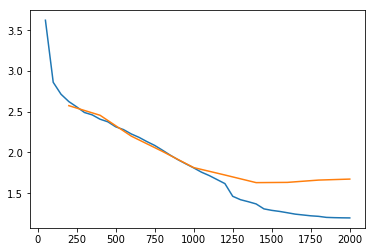

In [58]:
plt.plot([t[0] for t in train_ppls], [t[1] for t in train_ppls])
plt.plot([t[0] for t in dev_ppls], [t[1] for t in dev_ppls])

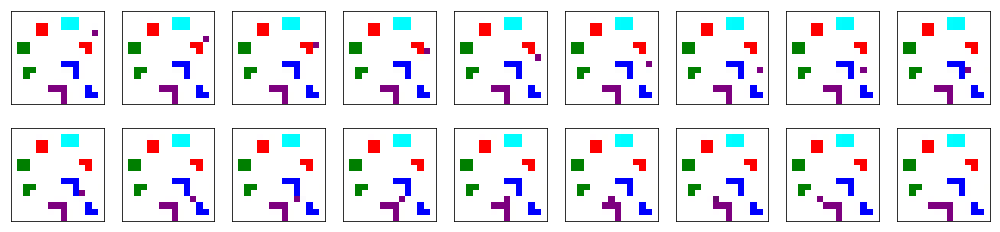

In [80]:
cap = cv2.VideoCapture(os.path.join('..', 'target', '0', '0.mp4'))

fig=plt.figure(figsize=(14, 3.5))

counter = 1

row = 2
col = 9
while (cap.isOpened()):
    ret, frame = cap.read()
    
    img = crop_and_resize(frame)
    
    a = fig.add_subplot(row, col, counter)
    
    a.get_xaxis().set_visible(False)
    a.axes.get_yaxis().set_visible(False)
    plt.imshow(img)
    
    counter += 1
    
    if counter > row * col:
        break
    
fig.tight_layout()
plt.show()

In [112]:
get_instructions ( os.path.join('..', 'target', '0', '0.mp4') )

There are 19 frames 
The list of instructions are ['down', 'down', 'down', 'down', 'down', 'down', 'left', 'left', 'down', 'down', 'left', 'left', 'left', 'left', 'left', 'left', 'down', 'left'] 


['down',
 'down',
 'down',
 'down',
 'down',
 'down',
 'left',
 'left',
 'down',
 'down',
 'left',
 'left',
 'left',
 'left',
 'left',
 'left',
 'down',
 'left']

### A function that input a video and a sequence of actions, produce the correct sequence of actions

In [118]:
def get_source_from_2_frames( prev_frame, cur_frame ):
    diff = abs(prev_frame.astype(np.int32) - cur_frame.astype(np.int32))
    vals = np.argwhere(diff >= 20)
    
    points = set()
    for val in vals:
        points.add(tuple(val[:2]))
    
    # if prev_frame[points[0]] ~ (255,255,255), points[0] is target, points[1] is start
    # otherwise reverse
    
    points = list(points)
    
    if np.sum(abs(prev_frame[points[0]].astype(np.int32) - np.array([255, 255, 255]))) > 20:
        source = np.array(points[0])
    else:
        source = np.array(points[1])
        
    return source

def move ( loc, action ):
    if action == 'left':
        return (loc[0], loc[1] - 1)
    if action == 'right':
        return (loc[0], loc[1] + 1)
    if action == 'up':
        return (loc[0] - 1, loc[1])
    if action == 'down':
        return (loc[0] + 1, loc[1])
    
def reverse_action ( action ):
    if action == 'left':
        return 'right'
    if action == 'right':
        return 'left'
    if action == 'up':
        return 'down'
    if action == 'down':
        return 'up'
        
def reenact( video_file, actions ):
    """
    Reading the first frame of video_file, 
    perform actions on the purple blocks, and regenerate the correct list of actions
    """
    cap = cv2.VideoCapture(video_file)
    
    # First 2 frames
    _, first_frame = cap.read()
    first_frame = crop_and_resize ( first_frame )
    _, second_frame = cap.read()
    second_frame = crop_and_resize ( second_frame )
    
    source = get_source_from_2_frames ( first_frame, second_frame )
    
    # Clear first_frame[tuple(source)]
    first_frame[tuple(source)] = [255, 255, 255]
    
    loc = source
    
    new_actions = []
    for action in actions:
        new_loc = move (loc, action)
        
        # Check if new_loc is legal move
        if 0 <= new_loc[0] <  first_frame.shape[0] and 0 <= new_loc[1] <  first_frame.shape[1]:
            # Check if new_loc is not occupied
            if np.sum(abs(first_frame[tuple(new_loc)].astype(np.int32) - np.array([255, 255, 255]))) > 20:
                # Not empty
                pass
            else:
                loc = new_loc
                new_actions.append(action)
    
    return new_actions

[123   0 124]


['right', 'down', 'down', 'left']

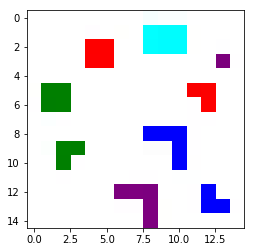

In [108]:
reenact ( os.path.join('..', 'target', '0', '0.mp4') , ['right', 'right', 'right', 'down', 'down', 'left', 'left', 'left', 'left'] )

In [134]:
refs = ['down', 'down', 'down', 'down', 'down', 'down', 'left', 'left', 'down', 'down', 'left', 'left', 'left', 'left', 'left', 'left', 'down', 'left']
preds = ['right', 'right', 'right', 'down', 'down', 'left', 'left', 'down', 'down', 'down', 'down', 'down', 'down']

def neighbor_score ( chain1, chain2):
    """
    Calculating neighboring scores from chain1 to chain2
    This code could be implemented with 4 heaps, but only efficient if the length of chain1, chain2 are large enough
    One heap for only positive pairs
    One heap for only negative pairs
    One heap for (positive, negative)
    One heap for (negative, positive)
    One remaining list for pair that has one value == 0 (that could change to one of the aforementioned heaps)
    
    However here we just do a very simple loop in this code
    """
    values = [(0,0)]
    for action in chain1:
        values.append ( move (values[-1], action) )
    
    shortest_vals = []
    for action in chain2:
        r_action = reverse_action ( action )
        
        values = [ move(value, r_action) for value in values]
        shortest_val = np.min( [abs(value[0]) + abs(value[1]) for value in values] )
        shortest_vals.append(shortest_val)
        
    return shortest_vals
    
    
def shortest_neighbor_score ( refs,  preds, video_file ):
    correct_preds = reenact( video_file, preds )
    
    score_1 = neighbor_score( refs , correct_preds )
    score_2 = neighbor_score( correct_preds, refs)
    
    total_val = sum(score_1) + sum(score_2)
    total_count = ( 1 # First cell
                + np.count_nonzero(score_1)
                + len(score_2) ) # score_1 and score_2 share cells that has value == 0
    return total_val / total_count
    

In [121]:
correct_preds = reenact( os.path.join('..', 'target', '0', '0.mp4'), preds )

In [122]:
correct_preds

['right',
 'down',
 'down',
 'left',
 'down',
 'down',
 'down',
 'down',
 'down',
 'down']

In [127]:
score_1 = neighbor_score ( refs, correct_preds )

In [128]:
score_2 = neighbor_score ( correct_preds, refs )

In [132]:
np.count_nonzero(score_1)

5

In [133]:
np.count_nonzero(score_2)

13

In [136]:
print (shortest_neighbor_score(refs, preds, os.path.join('..', 'target', '0', '0.mp4')))

2.75


In [137]:
total_val = sum(score_1) + sum(score_2)
total_count = ( 1 # First cell
            + np.count_nonzero(score_1)
            + len(score_2) ) # score_1 and score_2 share cells that has value == 0

In [138]:
total_val

66

In [139]:
total_count

24

In [140]:
score_1

[1, 1, 1, 0, 0, 0, 0, 0, 1, 2]

In [141]:
score_2

[1, 0, 0, 0, 0, 0, 1, 2, 2, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [146]:
def video_to_features (video_path):
    """
    Load a video file, rastering it into a sequence of feature vectors
    There might be different way to extracting features from each frame
    The easiest approach might be to ignore the color from the video, and just
    return an array of size 1
    """
    cap = cv2.VideoCapture(video_path)

    counter = 0
    
    frames = []
    
    while (cap.isOpened()):
        ret, frame = cap.read()

        if not ret:
            break
            
        small_frame = crop_and_resize ( frame )
        
        small_frame = np.sum ( small_frame, axis = 2 )
        
        t = (small_frame < ( 255+255+250-20 ) ) .astype(int)
        
        frames.append(t.flatten())
        
    return np.stack(frames)

In [147]:
q = video_to_features( os.path.join('..', 'target', '0', '0.mp4') )

In [148]:
q[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0])

### Add test instructions and commands

In [151]:
test_src_file = 'test_instructions.txt'
test_tgt_file = 'test_commands.txt'

instructions = []
with open(os.path.join('..', 'data', test_src_file), 'r') as fh:
    for line in fh:
        instructions.append(line.lower().strip())
        
with open(os.path.join('..', 'data', test_src_file), 'w') as fh:
    for instruction in instructions:
        fh.write(instruction)
        fh.write('\n')

with open(os.path.join('..', 'data', test_tgt_file), 'w') as fh:
    for puzzle in range(200, 300):
        instructions = puzzle_to_instructions[puzzle]

        directory = puzzle // 100

        commands = get_instructions(os.path.join('..', 'target', str(directory), str(puzzle) + '.mp4'), debug = False)

        fh.write(' '.join(commands))
        fh.write('\n')